#Setup and imports

In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 43.0 MB/s 
     |████████████████████████████████| 77 kB 5.1 MB/s 
     |████████████████████████████████| 6.5 MB 43.5 MB/s 
     |████████████████████████████████| 596 kB 40.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
from transformers import BertTokenizer, BertModel
# device = torch.device("cuda")
# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

#Getting strings of data

In [ ]:
#Upload the unzip and pickles of word embeddings

In [ ]:
! git clone https://github.com/parsafarinnia/semantic_change_porject.git

Cloning into 'semantic_change_porject'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 23 (delta 6), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [ ]:
c1_raw = []
c1_raw_strings = ''

with open("/content/ccoha1.txt") as fileobject:
    for i,line in enumerate(fileobject):
      if i%80==0:
        c1_raw_strings += line

c2_raw_strings = ''

with open("/content/ccoha2.txt") as fileobject:
    for i,line in enumerate(fileobject):
      if i%80==0:
        c2_raw_strings += line  

In [ ]:
import re

regex = re.compile('[^a-zA-Z]')
#First parameter is the replacement, second parameter is your input string
c2_raw_strings=regex.sub(' ', c2_raw_strings)
c1_raw_strings=regex.sub(' ', c1_raw_strings)

#Helper functions

In [ ]:

def chunk_text(some_string,x):
  some_string = some_string.split()
  for i in range(0, len(some_string), x):
          yield some_string[i:i + x]

In [ ]:
def divide_chunks(l, n):
      
    # looping till length l
    result = []
    for i in range(0, len(l), n): 
        result.append(l[i:i + n])
    return result

In [ ]:
def clean_and_tokenize(tokenizer_version,text):
  #Tokenize text 
  tokenized_cls = tokenizer_version.tokenize("[CLS]")
  tokenized_sep = tokenizer_version.tokenize("[SEP]")
  tokenized_text = tokenizer_version.tokenize(text)
  #divide to 510 chunks
  batches_text = divide_chunks(tokenized_text,510)
  #add [CLS] and [SEP] tokens to each batch
  for batch in batches_text:
    batch.insert(0,tokenized_cls[0])
    batch.append(tokenized_sep[0])
  batches_text = batches_text[:-1]
  batches_id = []
  #get IDs of each batch
  for batch in batches_text:
    indexed_tokens = tokenizer_version.convert_tokens_to_ids(batch)
    batches_id.append(indexed_tokens)
  return batches_text, batches_id
# Tokenize all of the sentences and map the tokens to thier word IDs.
def tokenizer_func(tokenizer_kind,sentences):
  '''
  inputs:
    tokenizer_kind: is the the tokenizer of choice (normal bert, tweet bert)  
    sentences: the input string of curpos
  outputs:
  torchs of 
    ids : tensor of size len(input string)/512 X 512
    segments: tensor of size len(input string)/512 X 512
    tokenized tex :list of size len(input string)/512 X 512
  '''
  # For all the string
  batches_text, batches_id = clean_and_tokenize(tokenizer_kind,sentences)
  segments = [[1]*512]*len(batches_id)

  return torch.Tensor(batches_id), torch.Tensor(segments),batches_text

In [ ]:
# #T
#Make inverse word map fictionary
word_list = []
for batch in tokenized_texts:
  word_list.extend(batch)
inv_word_map = {}
for i, word in enumerate(word_list):
  inv_word_map[i] = word

In [ ]:
def average_embeddings(token_embeddings):
  for token in token_embeddings:
    sum_vec = torch.mean(token[-4:], dim=0)


In [ ]:
# def word_rep_to_dic(c1_raw_string):
c1_raw_string =c2_raw_strings
input_ids, segments,tokenized_texts=tokenizer_func(tokenizer,c1_raw_string)
print('tokenizing done')
input_ids = torch.tensor(input_ids).long()
segments = torch.tensor(segments).long()
print('input_ids shape',input_ids.size())
word_list = []
for batch in tokenized_texts:
  word_list.extend(batch)
inv_word_map = {}
for i, word in enumerate(word_list):
  inv_word_map[i] = word

tokenizing done
input_ids shape torch.Size([180, 512])


In [ ]:
del c2_raw_strings
del c1_raw_string

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased',
                                output_hidden_states = True, # Whether the model returns all hidden-states.
                                )
model.to(device)

# Put the model in "evaluation" mode, meaning feed-forward operation.
bs = 10
number_of_batch = int(input_ids.size()[0]/bs)
print('number of batches are: ', number_of_batch)
last_batch_size = input_ids.size()[0] - number_of_batch*bs
model.eval()
hidden_states_all = []
with torch.no_grad():
  for i in range(number_of_batch):
    print('progres===> batch number',i)
    # if i == number_of_batch-1:
    #   upper = last_batch_size
    # else:
    upper = (i+1)*bs
    batch_inputZ_ids = input_ids[i*bs:upper,:]
    batch_inputZ_ids = batch_inputZ_ids.to(device)
    batch_segments = segments[i*bs:upper,:]
    batch_segments = batch_segments.to(device)
    outputs = model(batch_inputZ_ids, batch_segments)
    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]
    # for idx in range(13):
    #   print(type(hidden_states[idx]))
    #   print(len(hidden_states[idx]))
    #   print(hidden_states[idx])
    hidden_states = torch.stack(hidden_states, dim=0)
    hidden_states = hidden_states.detach().cpu()
    hidden_states_all.append(hidden_states)
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


number of batches are:  18
progres===> batch number 0
progres===> batch number 1
progres===> batch number 2
progres===> batch number 3
progres===> batch number 4
progres===> batch number 5
progres===> batch number 6
progres===> batch number 7
progres===> batch number 8
progres===> batch number 9
progres===> batch number 10
progres===> batch number 11
progres===> batch number 12
progres===> batch number 13
progres===> batch number 14
progres===> batch number 15
progres===> batch number 16
progres===> batch number 17


In [ ]:


token_embeddings = torch.cat(hidden_states_all, dim=1)
print(token_embeddings.size())
# token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings = token_embeddings.permute(1,2,0,3)
token_embeddings = token_embeddings.flatten(0,1)
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)
word_vec_pre_process = {}
for i,vector in enumerate(token_vecs_sum):
  if inv_word_map[i] not in word_vec_pre_process:
    word_vec_pre_process[inv_word_map[i]] = (vector.unsqueeze(0),0) 
  else:
    word_vec_pre_process[inv_word_map[i]] = (torch.cat((word_vec_pre_process[inv_word_map[i]][0],vector.unsqueeze(0)),dim=0), word_vec_pre_process[inv_word_map[i]][1]+1)  
for word in word_vec_pre_process:
  word_vec_pre_process[word] = (torch.mean(word_vec_pre_process[word][0], dim=0),word_vec_pre_process[word][1])
  

  # return word_vec_pre_process


In [ ]:
del token_embeddings
del token_vecs_sum 

#Getting word embeddings and frequencies

##building the dictionaries

In [ ]:
test_dic_2 = word_vec_pre_process
import pickle
with open('test_dic_2.pickle', 'wb') as handle:
    pickle.dump(test_dic_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [ ]:
# test_dic_2 = word_rep_to_dic(c2_raw_string)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##Filtering sub words with hashtag and [CLS] and [SEP] and punctuation and using word representations from memmory to avoid crash

In [ ]:
import pickle
with open('/content/test_dic_1.pickle', 'rb') as handle:
    test_dic_1 = pickle.load(handle)
with open('/content/test_dic_2.pickle', 'rb') as handle:
    test_dic_2 = pickle.load(handle)

In [ ]:
test_dic_1 = {key: value for key, value in test_dic_1.items() if((not key.startswith('##')) and (not key =='[SEP]') and (not key =='[CLS]'))}
test_dic_2 = {key: value for key, value in test_dic_2.items() if((not key.startswith('##')) and (not key =='[SEP]') and (not key =='[CLS]'))}

#MLM fine tuning

In [5]:
load_tokenized = False
BERT_name = 'VANILLA'
models = {
          'VANILLA':"bert-base-uncased"
        }
model_name = models[BERT_name] 

rev_per_res = 200
bs = 16
MAX = 512

In [6]:
from transformers import AutoTokenizer, AutoModel,BertForPreTraining,AutoModelForMaskedLM
import torch

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForMaskedLM.from_pretrained(model_name)

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
def tokenizer_func(tokenizer_kind,sentences,max_length=512):
 
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in tqdm(sentences):
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer_kind.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = max_length,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                          truncation=True,
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  inputs = {}
  inputs['input_ids'] = input_ids
  inputs['attention_mask'] = attention_masks
  
  return inputs
  # Print sentence 0, now as a list of IDs.

In [ ]:
# for text in tqdm(texts):

if not load_tokenized:
  # df = pd.read_csv('./drive/MyDrive/SIGIR 2022/Cleaned_Data/400_review_3_star_above - 400_review_3_star_above.csv')
  df_val = pd.read_csv('./drive/MyDrive/CSC2611/vall_data 512.csv')
  df_train = pd.read_csv('./drive/MyDrive/CSC2611/train_data 512.csv')

  train_text = list(df_train.text.values)
  val_text = list(df_val.text.values)
  # print(len(train_text),len(val_text))

  inputs = tokenizer_func(tokenizer,train_text, MAX)
  val_inputs = tokenizer_func(tokenizer,val_text, MAX)
  # inputs['labels'] = inputs.input_ids.detach().clone()
  torch.save(inputs,'train_'+str(MAX)+'_'+BERT_name+'.pt')
  torch.save(val_inputs,'val_'+str(MAX)+'_'+BERT_name+'.pt')
  print('Saved the tokenized data with truncation at ',MAX)


(25658, 8)
10000 1280
10000 1280


  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 1280/1280 [00:00<00:00, 1334.99it/s]


Saved the tokenized data with truncation at  512


In [ ]:
inputs['labels'] = inputs['input_ids'].detach().clone()
val_inputs['labels'] = val_inputs['input_ids'].detach().clone()

In [ ]:
# create random array of floats with equal dimensions to input_ids tensor
def get_mask(inp):
  ids = inp['input_ids'].reshape(1,-1)
  rand = torch.rand(ids.shape)
  # create mask array
  # MASK 103, CLS 101, SEP 102
  mask_arr = (rand < 0.15) * (ids != 101) * \
            (ids != 102) * (ids != 0)
  selection = []
  mask_arr = mask_arr.long()
  # print(mask_arr)
  for i in range(ids.shape[0]):
      selection.append(
          torch.flatten(mask_arr[i].nonzero()).tolist()
      )
  return selection

In [ ]:
class MeditationsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        
        d = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} 
        s = get_mask(d)
        # print(d['input_ids'].reshape(1,-1),s)
        # for i in range(d['input_ids'].shape[0]):
        d['input_ids'][s[0]] = 103
        return d
    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
dataset = MeditationsDataset(inputs)
val_dataset = MeditationsDataset(val_inputs)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# and move our model over to the selected device
print(device)
model.to(device)
# activate training mode
model.train()
print('ready')

cuda
ready


In [ ]:
from transformers import TrainingArguments
args = TrainingArguments(
    output_dir=BERT_name+'_'+str(bs)+'_'+str(MAX)+'_MLM',
    per_device_train_batch_size=bs,
    per_device_eval_batch_size = bs,
    num_train_epochs=100,
    learning_rate=1e-05,
    load_best_model_at_end =True,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    logging_strategy = "epoch",
)

In [ ]:
from transformers import Trainer,EarlyStoppingCallback


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset,
    eval_dataset= val_dataset,
    callbacks = [EarlyStoppingCallback(4,0.0)]
)

In [ ]:
trainer.train()

#Calculating the semantic perserving words

##Getting semantic changed words with 

In [ ]:
same_words = list(set(set(test_dic_2.keys()) & set(test_dic_1.keys())))
len(same_words)

4708

In [ ]:
difference_dict = {}
cos = torch.nn.CosineSimilarity(dim=0)
for word in same_words:
  difference_dict[word] = (float(cos(test_dic_1[word][0],test_dic_2[word][0]).numpy().astype(np.float32)),(min(test_dic_1[word][1],test_dic_2[word][1])))

In [ ]:
# difference_dict.items()

dict_items([('deep', (0.7036608457565308, 0)), ('beat', (0.5960277318954468, 0)), ('appoint', (0.6637331247329712, 0)), ('of', (0.986420750617981, 49)), ('yes', (0.6626576781272888, 0)), ('hi', (0.4077017605304718, 0)), ('most', (0.5904287695884705, 0)), ('ho', (0.6089327335357666, 0)), ('button', (0.49415773153305054, 0)), ('weapon', (0.6826935410499573, 0)), ('same', (0.8062039017677307, 0)), ('influence', (0.6105726957321167, 0)), ('himself', (0.8774850964546204, 2)), ('head', (0.7683360576629639, 1)), ('trouble', (0.7637346982955933, 0)), ('have', (0.9739115238189697, 23)), ('person', (0.7376757264137268, 0)), ('often', (0.8121248483657837, 0)), ('discharge', (0.676744818687439, 0)), ('species', (0.729433000087738, 0)), ('el', (0.38551852107048035, 0)), ('think', (0.8257969617843628, 0)), ('people', (0.8704149127006531, 2)), ('st', (0.5560790300369263, 0)), ('i', (0.9432547688484192, 10)), ('tender', (0.6984021067619324, 0)), ('time', (0.8781933188438416, 3)), ('know', (0.703051209

In [ ]:
difference_dict_sorted_by_score=sorted(difference_dict.items(), key=lambda x: x[1][0], reverse=True)
difference_dict_sorted_by_freq=sorted(difference_dict.items(), key=lambda x: x[1][1], reverse=True)

In [ ]:
difference_dict_sorted_by_score[:10]

[('or', (0.9845697283744812, 274)),
 ('see', (0.9826090931892395, 152)),
 ('would', (0.982541561126709, 196)),
 ('them', (0.9818414449691772, 151)),
 ('nu', (0.9811897873878479, 85)),
 ('they', (0.9806659817695618, 303)),
 ('her', (0.9805899262428284, 382)),
 ('if', (0.980434775352478, 223)),
 ('when', (0.9803611636161804, 206)),
 ('two', (0.9795575737953186, 78))]

##Choosing fixed points

In [ ]:
#Choosing words with high frequency as 
portion_of_top_freq = 0.1
top_k_freq= int(len(difference_dict_sorted_by_freq) * portion_of_top_freq)

top_k_freq_words = [word[0] for word in difference_dict_sorted_by_freq[:top_k_freq]]

In [ ]:
top_k_freq_words[:20]

['the',
 'be',
 'and',
 'of',
 'to',
 'a',
 'in',
 'have',
 'that',
 'i',
 'it',
 'he',
 'for',
 'his',
 'with',
 'as',
 'at',
 'you',
 'but',
 'her']

In [ ]:
top_k_freq

470

In [ ]:
#Choosing fixed points with low semantic change
number_of_fixed_words = 65
top_scoring_words = [word[0] for word in difference_dict_sorted_by_score[:min(number_of_fixed_words*30,len(difference_dict_sorted_by_score))]][:number_of_fixed_words]

In [ ]:
fixed_words = top_scoring_words

In [ ]:
fixed_words_c1 = {}
fixed_words_c2 = {}
for word in fixed_words:
  fixed_words_c1[word] = test_dic_1[word][0]
  fixed_words_c2[word] = test_dic_2[word][0]

#Comparing target words with fixed points

In [ ]:
target_truth_task1={}
target_truth_task2={}
with open("/content/semantic_change_porject/english (2).txt") as fileobject:
    for i,line in enumerate(fileobject):
      target_truth_task2[line.split()[0].split('_')[0]] =  line.split()[1]



with open("/content/semantic_change_porject/english.txt") as fileobject:
    for i,line in enumerate(fileobject):
      target_truth_task1[line.split()[0].split('_')[0]] =  line.split()[1]

In [ ]:
target_words= target_truth_task2.keys()
target_words_present = list(set(set(same_words) & set(target_words)))
target_words_not_present = [word for word in target_words if word not in target_words_present]


In [ ]:
#Getting target words
#For now
target_words = target_words_present
target_words_c1_rep = {}
target_words_c2_rep = {}
for word in target_words:
  target_words_c1_rep[word] = test_dic_1[word][0]
  target_words_c2_rep[word] = test_dic_2[word][0]
target_words_diff = {}
for target_word in target_words:
  word_rep_c1 = []
  word_rep_c2 = []
  for fixed_word in fixed_words:
    dist_word_to_fix_c1 = 1-float(cos(target_words_c1_rep[target_word],fixed_words_c1[fixed_word]).numpy().astype(np.float32))
    dist_word_to_fix_c2 = 1-float(cos(target_words_c2_rep[target_word],fixed_words_c2[fixed_word]).numpy().astype(np.float32))
    word_rep_c1.append(dist_word_to_fix_c1)
    word_rep_c2.append(dist_word_to_fix_c2)

  target_words_diff[target_word] = {
      'c1': word_rep_c1,
      'c2': word_rep_c2
  }
#out put is target_words_diff

In [ ]:
#trying cosine 
from sklearn.metrics.pairwise import cosine_similarity
target_words_diff_score_cosine = {}
for word in target_words_diff:
  target_words_diff_score_cosine[word] =1- cosine_similarity([target_words_diff[word]['c1']], [target_words_diff[word]['c2']])[0][0]



In [ ]:
result_cosine=sorted(target_words_diff_score_cosine.items(), key=lambda x: x[1], reverse=True)

In [ ]:
prediction = {}
task1_gt = []
task2_gt = []
prediction_task_2 = []
for word in result_cosine:
  task1_gt.append(int(target_truth_task1[word[0]]))
  prediction_task_2.append((word[1]))
  prediction[word[0]] = (word[1],target_truth_task1[word[0]],target_truth_task2[word[0]])
  task2_gt.append(target_truth_task2[word[0]])
  print('word ',word[0], ' -result: ',word[1],' binary truth of semantic change: ',target_truth_task1[word[0]])
results_cosine_task2 = [prediction_task_2,task2_gt,task1_gt]

word  bit  -result:  0.0014005141835496948  binary truth of semantic change:  1
word  stab  -result:  0.001340821343941423  binary truth of semantic change:  1
word  thump  -result:  0.0011790924765886501  binary truth of semantic change:  1
word  multitude  -result:  0.0011614570654803202  binary truth of semantic change:  0
word  plane  -result:  0.001002191250322415  binary truth of semantic change:  1
word  quilt  -result:  0.0009999325757332755  binary truth of semantic change:  0
word  record  -result:  0.0008756957945711408  binary truth of semantic change:  1
word  tip  -result:  0.0007779623301791272  binary truth of semantic change:  1
word  stroke  -result:  0.0007708830015382695  binary truth of semantic change:  0
word  player  -result:  0.0006429535206379233  binary truth of semantic change:  1
word  savage  -result:  0.0006386506289202121  binary truth of semantic change:  0
word  bag  -result:  0.0006356232933962813  binary truth of semantic change:  0
word  gas  -resul

In [ ]:
#Trying averaging
target_words_diff_score_avg = {}

for word in target_words_diff:
  target_words_diff_score_avg[word] =abs(sum([target_words_diff[word]['c1']][0]) - sum([target_words_diff[word]['c2']][0]))

In [ ]:
result_avg=sorted(target_words_diff_score_avg.items(), key=lambda x: x[1], reverse=True)

In [ ]:
predection = {}
task1_gt = []
task2_gt = []
prediction_task_2 = []
for word in result_avg:
  task1_gt.append(target_truth_task1[word[0]])
  prediction_task_2.append(word[1])
  task2_gt.append(target_truth_task2[word[0]])
results_avg_task2 = [prediction_task_2,task2_gt,task1_gt]

In [ ]:
a= 0
r = {word[0]:results_cosine_task2[2][i] for i ,word in enumerate(result_cosine)}
r


{'attack': 1,
 'bag': 0,
 'ball': 0,
 'bit': 1,
 'circle': 1,
 'donkey': 0,
 'edge': 1,
 'face': 0,
 'fiction': 0,
 'gas': 0,
 'head': 1,
 'land': 1,
 'multitude': 0,
 'ounce': 0,
 'part': 0,
 'pin': 0,
 'plane': 1,
 'player': 1,
 'prop': 1,
 'quilt': 0,
 'rag': 1,
 'record': 1,
 'relationship': 0,
 'risk': 0,
 'savage': 0,
 'stab': 1,
 'stroke': 0,
 'thump': 1,
 'tip': 1,
 'tree': 0,
 'twist': 0,
 'word': 0}

#Comparing non fixed point based with fixed point based

In [ ]:
target_words = target_words_present
target_words_c1_rep = {}
target_words_c2_rep = {}
for word in target_words:
  target_words_c1_rep[word] = test_dic_1[word][0]
  target_words_c2_rep[word] = test_dic_2[word][0]
target_words_diff_normal = {}
for target_word in result_cosine:
  dist_word_to_from_other_c = 1-float(cos(target_words_c1_rep[target_word[0]],target_words_c2_rep[target_word[0]]).numpy().astype(np.float32))
  target_words_diff_normal[target_word[0]]=dist_word_to_from_other_c


In [ ]:
arget_words_diff_normal_list = [target_words_diff_normal[word] for word in target_words_diff_normal]
print('results for avg no fix points:',stats.spearmanr(arget_words_diff_normal_list, results_cosine_task2[1])[0])

results for avg no fix points: 0.11511318900880745


#Calculating for task 1 and 2

In [ ]:
#For Task 1 I calculate the average and look for those above average and by looking and the plot of threshold

In [ ]:
results_cosine_task2[1]

['0.3065766263',
 '0.4005896829',
 '0.1429915711',
 '0.1003636619',
 '0.8823475834',
 '0.1231453661',
 '0.4273504707',
 '0.6788987615',
 '0.1762311532',
 '0.2736674651',
 '0.0968689424',
 '0.1003636619',
 '0.1595695865',
 '0.624759971',
 '0.1710871199',
 '0.3984926634',
 '0.2765152931',
 '0.0207232682',
 '0.2072118595',
 '0.2848990681',
 '0',
 '0.0562177896',
 '0.1439699927',
 '0.161270809',
 '0.4093665525',
 '0.2609655868',
 '0.1601038896',
 '0.1793071623',
 '0.2952561247',
 '0.2234476353',
 '0.137791275',
 '0.070838721']

In [ ]:
from scipy import stats
print('results for best avg:',stats.spearmanr(results_avg_task2[0], results_avg_task2[1])[0])
print('results for best cosine:',stats.spearmanr(results_cosine_task2[0], results_cosine_task2[1])[0])

results for best avg: -0.0945834482938609
results for best cosine: 0.22216112273674302


In [ ]:
from sklearn.metrics import accuracy_score

# accuracy_score(y_true, y_pred)
for i in range(len(results_cosine_task2[2])):
  pred = [0 for j in range(len(results_cosine_task2[2]))]
  
  for j in range(i):
    pred[j] = 1
  
  print(i,'acc ',accuracy_score(results_cosine_task2[2], pred))

0 acc  0.5625
1 acc  0.59375
2 acc  0.625
3 acc  0.65625
4 acc  0.625
5 acc  0.65625
6 acc  0.625
7 acc  0.65625
8 acc  0.6875
9 acc  0.65625
10 acc  0.6875
11 acc  0.65625
12 acc  0.625
13 acc  0.59375
14 acc  0.625
15 acc  0.65625
16 acc  0.625
17 acc  0.65625
18 acc  0.625
19 acc  0.59375
20 acc  0.5625
21 acc  0.53125
22 acc  0.5
23 acc  0.53125
24 acc  0.5
25 acc  0.46875
26 acc  0.5
27 acc  0.46875
28 acc  0.4375
29 acc  0.46875
30 acc  0.5
31 acc  0.46875


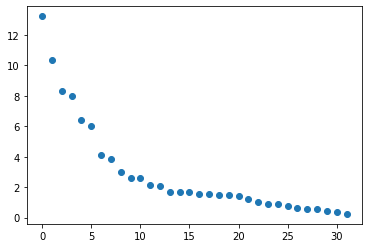

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#final method of score aggregation
final_scoring = [word[1] for word in result_avg]
y = np.array(final_scoring)
x = np.array(range(0,len(y)))

plt.scatter(x, y)
plt.show()

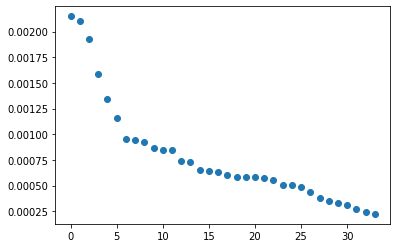

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#final method of score aggregation
final_scoring = [word[1] for word in result_cosine]

y = np.array(final_scoring)
x = np.array(range(0,len(y)))

plt.scatter(x, y)
plt.show()

#Number of fix points and performance

In [ ]:
def get_num_fix_point(number_of_fixed_words,target_words=target_truth_task2.keys()):
  number_of_fixed_words = number_of_fixed_words
  target_words= target_truth_task2.keys()

  top_scoring_words = [word[0] for word in difference_dict_sorted_by_score[:min(number_of_fixed_words*30,len(difference_dict_sorted_by_score))]][:number_of_fixed_words]
  fixed_words = top_scoring_words
  fixed_words_c1 = {}
  fixed_words_c2 = {}
  for word in fixed_words:
    fixed_words_c1[word] = test_dic_1[word][0]
    fixed_words_c2[word] = test_dic_2[word][0]
  target_words = target_words_present
  target_words_c1_rep = {}
  target_words_c2_rep = {}
  for word in target_words:
    target_words_c1_rep[word] = test_dic_1[word][0]
    target_words_c2_rep[word] = test_dic_2[word][0]
  target_words_diff = {}
  for target_word in target_words:
    word_rep_c1 = []
    word_rep_c2 = []
    for fixed_word in fixed_words:
      dist_word_to_fix_c1 = 1-float(cos(target_words_c1_rep[target_word],fixed_words_c1[fixed_word]).numpy().astype(np.float32))
      dist_word_to_fix_c2 = 1-float(cos(target_words_c2_rep[target_word],fixed_words_c2[fixed_word]).numpy().astype(np.float32))
      word_rep_c1.append(dist_word_to_fix_c1)
      word_rep_c2.append(dist_word_to_fix_c2)

    target_words_diff[target_word] = {
        'c1': word_rep_c1,
        'c2': word_rep_c2
    }
  from sklearn.metrics.pairwise import cosine_similarity
  target_words_diff_score_cosine = {}
  for word in target_words_diff:
    target_words_diff_score_cosine[word] =1- cosine_similarity([target_words_diff[word]['c1']], [target_words_diff[word]['c2']])[0][0]
  result_cosine=sorted(target_words_diff_score_cosine.items(), key=lambda x: x[1], reverse=True)
  predection = {}
  task1_gt = []
  task2_gt = []
  prediction_task_2 = []
  for word in result_cosine:
    task1_gt.append(int(target_truth_task1[word[0]]))
    prediction_task_2.append((word[1]))

    task2_gt.append(target_truth_task2[word[0]])
    # print('word ',word[0], ' -result: ',word[1],' binary truth of semantic change: ',target_truth_task1[word[0]])
  results_cosine_task2 = [prediction_task_2,task2_gt,task1_gt]

  return stats.spearmanr(results_cosine_task2[0], results_cosine_task2[1])[0]

In [ ]:
fix_words_num = [get_num_fix_point(i) for i in range(1,400)]

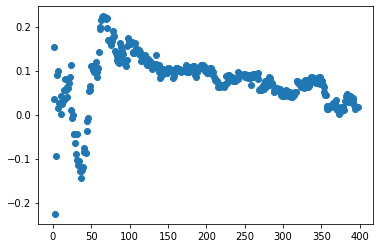

In [ ]:


y = np.array(fix_words_num)
x = np.array(range(0,len(y)))

plt.scatter(x, y)
plt.show()

#Comparing with frequency baseline

In [ ]:
freqs = {'attack': [454, 833], 'bag': [214, 899], 'ball': [440, 878], 'bit': [296, 622],
          'circle': [131, 245],  'donkey': [118, 148],
         'edge': [457, 1072], 'face': [3394, 3932], 'fiction': [202, 326], 'gas': [155, 680],
          'head': [3599, 4127], 'land': [2321, 1624], 
         'lass': [111, 106], 'multitude': [475, 131], 'ounce': [208, 189], 'part': [4410, 3213],
         'pin': [114, 217], 'plane': [278, 792], 'player': [132, 939], 'prop': [121, 147],
         'quilt': [106, 189], 'rag': [158, 208], 'record': [420, 1188], 'relationship': [130, 841],
         'risk': [286, 643], 'savage': [504, 133], 'stab': [92, 117], 'stroke': [110, 227],
         'thump': [89, 127], 'tip': [119, 241], 'tree': [2322, 1596], 'twist': [103, 186],
         'word': [4387, 3166]}

In [ ]:
prediction

{'attack': (0.00041906636298227884, '1', '0.1439699927'),
 'bag': (0.0006356232933962813, '0', '0.1003636619'),
 'ball': (0.00034500227220146673, '0', '0.4093665525'),
 'bit': (0.0014005141835496948, '1', '0.3065766263'),
 'circle': (0.0005405150154823568, '1', '0.1710871199'),
 'donkey': (0.00031542613365564964, '0', '0.1601038896'),
 'edge': (0.0003277821176359552, '1', '0.2609655868'),
 'face': (0.00018930090741442474, '0', '0.137791275'),
 'fiction': (0.0004989377906956527, '0', '0.0207232682'),
 'gas': (0.0006198537350170508, '0', '0.1595695865'),
 'head': (0.00023467914446717586, '1', '0.2952561247'),
 'land': (0.00020207941652317096, '1', '0.2234476353'),
 'multitude': (0.0011614570654803202, '0', '0.1003636619'),
 'ounce': (0.0004922406894714015, '0', '0.2848990681'),
 'part': (0.00035978669681580033, '0', '0.161270809'),
 'pin': (0.0004953887365953813, '0', '0.2072118595'),
 'plane': (0.001002191250322415, '1', '0.8823475834'),
 'player': (0.0006429535206379233, '1', '0.273667

In [ ]:
freq_list = []
first_c_freq = []
prediction_list = []
gt_task2 = []
for word in prediction:

  freq_list.append(freqs[word])
  first_c_freq.append(min(freqs[word][0],freqs[word][1]))
  prediction_list.append(prediction[word][0])
  gt_task2.append(prediction[word][2])
  prediction[word] = (*prediction[word],freqs[word])

In [ ]:
# Word: predicted LSC, ground truth binary LSC, ground truth LSC, Frequencies
prediction

{'attack': (0.00041906636298227884, '1', '0.1439699927', [454, 833]),
 'bag': (0.0006356232933962813, '0', '0.1003636619', [214, 899]),
 'ball': (0.00034500227220146673, '0', '0.4093665525', [440, 878]),
 'bit': (0.0014005141835496948, '1', '0.3065766263', [296, 622]),
 'circle': (0.0005405150154823568, '1', '0.1710871199', [131, 245]),
 'donkey': (0.00031542613365564964, '0', '0.1601038896', [118, 148]),
 'edge': (0.0003277821176359552, '1', '0.2609655868', [457, 1072]),
 'face': (0.00018930090741442474, '0', '0.137791275', [3394, 3932]),
 'fiction': (0.0004989377906956527, '0', '0.0207232682', [202, 326]),
 'gas': (0.0006198537350170508, '0', '0.1595695865', [155, 680]),
 'head': (0.00023467914446717586, '1', '0.2952561247', [3599, 4127]),
 'land': (0.00020207941652317096, '1', '0.2234476353', [2321, 1624]),
 'multitude': (0.0011614570654803202, '0', '0.1003636619', [475, 131]),
 'ounce': (0.0004922406894714015, '0', '0.2848990681', [208, 189]),
 'part': (0.00035978669681580033, '0',

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler_pred = MinMaxScaler()
scaled_pred = scaler_pred.fit_transform(np.array(prediction_list).reshape(-1, 1))

scaler_gt = MinMaxScaler()
scaled_gt = scaler_gt.fit_transform(np.array(gt_task2).reshape(-1, 1))

scaled_freq_change = []
for freq in freq_list:
  scaled_freq_change.append((freq[1]-freq[0])/freq[0]*100)



(0.0, 1.3)

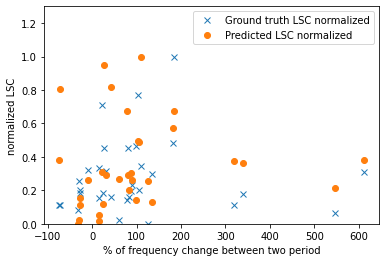

In [ ]:
'''
plots:
  #1, X: freq change, Y:prediction and gt
  #2, X: min freq, Y:Prediction and gt
'''



# plot 1 X: freq change, Y:prediction and gt



rng = np.random.RandomState(0)
# for marker in ['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']:
plt.plot(scaled_freq_change, scaled_gt, 'x',label="Ground truth LSC normalized")
plt.plot(scaled_freq_change, scaled_pred, 'o',label="Predicted LSC normalized")
plt.legend(loc=1)
plt.xlabel('% of frequency change between two period')
plt.ylabel('normalized LSC')
plt.ylim(0,1.3)


(0.0, 1.3)

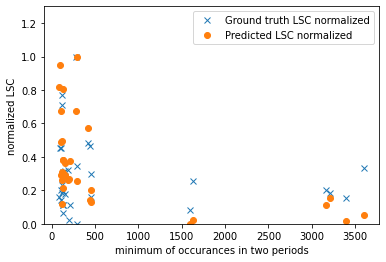

In [ ]:
rng = np.random.RandomState(0)
# for marker in ['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']:
plt.plot(first_c_freq, scaled_gt, 'x',label="Ground truth LSC normalized")
plt.plot(first_c_freq, scaled_pred, 'o',label="Predicted LSC normalized")
plt.legend(loc=1)
plt.xlabel('minimum of occurances in two periods')
plt.ylabel('normalized LSC')
plt.ylim(0,1.3)
